In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

inch = 2.54
x_range = [0, 0.2]
case_name = "PaSR"
line_arr = ('-','--','-.',':')
color_arr = ('k','r','b','y','g', 'c','m')
symbol_arr = ('s','o','v','^','*')

data_path = '../../data'
# target_case = 'KerM01_NH3_1e-1CEM'
target_case = 'MC_NH3CEM'

data_cols = ['OH', 'NO', 'Qdot','CEM','MF']
# data_cols = ['NH2', 'NH', 'HNO', 'HONO', 'H2O2', 'H2NN', 'N2H2', 'NO3', 'Qdot']


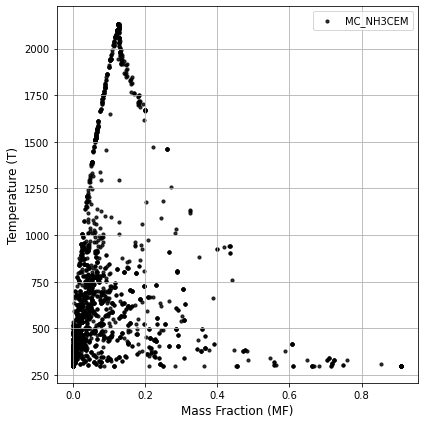

In [2]:
original_data_path = os.path.join(data_path, case_name, target_case) + ".csv"
df_original = pd.read_csv(original_data_path)

# Create the plot
fig, ax = plt.subplots(figsize=(6, 6))  # Fix figure size and axes
ax.scatter(df_original['MF'].to_numpy(), df_original['T'].to_numpy(),  # Convert to NumPy array for T
            label=f'{target_case}', 
            s=10, 
            alpha=0.8, 
            marker='o', 
            color='black')  # Original data in black

# Add labels and title
ax.set_xlabel('Mass Fraction (MF)', fontsize=12)
ax.set_ylabel('Temperature (T)', fontsize=12)
# ax.set_title(f'Temperature vs Mass Fraction for {target_case}', fontsize=14)

# Add grid and legend
ax.grid(True)
ax.legend()

# Tight layout for better spacing
plt.tight_layout()

# Save the figure
fig_dir = "figs/NH3_PaSR"
os.makedirs(fig_dir, exist_ok=True)
plt.savefig(os.path.join(fig_dir, f"1D_CEQ_{target_case}_T_vs_MF.png"), dpi=300)

# Show the plot
plt.show()

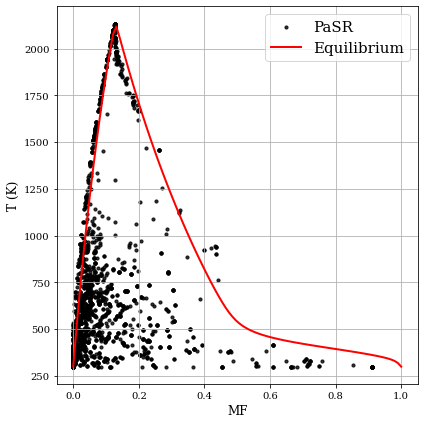

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cantera as ct
from copy import deepcopy

#%% Inputs and Data Loading
# Define your paths and target case
original_data_path = os.path.join(data_path, case_name, target_case) + ".csv"
df_original = pd.read_csv(original_data_path)

#%% Create the plot for original data
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(df_original['MF'].to_numpy(), df_original['T'].to_numpy(),
           label=f'PaSR', s=10, alpha=0.8, marker='o', color='black')

#%% Setup Cantera and Inputs
mech_path = "/data/ZhuXu/Cantera/CEMA/mechanism/NH3/NH3_otomo.cti"
gas = ct.Solution(mech_path)

# Define input parameters
inputs = {
    'temperature': 300,         # initial temperature in Kelvin
    'pressure': 1.0,            # pressure in atm (will be converted using ct.one_atm)
    'fuel': {'H2': 0.2, 'NH3': 0.8},
    'oxidizer': {'O2': 0.21, 'N2': 0.79}
}

# Calculate Zst at stoichiometric condition (equivalence ratio = 1.0)
gas.TP = inputs['temperature'], inputs['pressure'] * ct.one_atm
gas.set_equivalence_ratio(1.0, inputs['fuel'], inputs['oxidizer'])
Zst = gas.mixture_fraction(inputs['fuel'], inputs['oxidizer'])

#%% Compute Equilibrium Line with Modified Equivalence Ratio
mfs = np.linspace(0, 1, 100)
Teq = []

for Z in mfs:
    # Reset state for each mixture fraction
    gas.TP = inputs['temperature'], inputs['pressure'] * ct.one_atm
    if Z != 1:
        # Compute phi using the relation: phi = Z/(1-Z) * (1-Zst)/Zst
        phi = Z / (1 - Z) * (1 - Zst) / Zst
        gas.set_equivalence_ratio(phi, inputs['fuel'], inputs['oxidizer'])
    else:
        # When Z is 1, set the state to pure fuel
        gas.X = inputs['fuel']
    gas.equilibrate('HP')
    Teq.append(deepcopy(gas.T))

#%% Plot the Equilibrium Line
ax.plot(mfs, Teq, label='Equilibrium', color='red', linewidth=2)

# Finalize the plot
ax.set_xlabel('MF', fontsize=12)
ax.set_ylabel('T (K)', fontsize=12)
ax.grid(True)
ax.legend(fontsize=15)
plt.tight_layout()

# Save and show the figure
fig_dir = "figs/NH3_PaSR"
os.makedirs(fig_dir, exist_ok=True)
plt.savefig(os.path.join(fig_dir, f"1D_CEQ_{target_case}_T_vs_MF.pdf"), dpi=300)
plt.show()

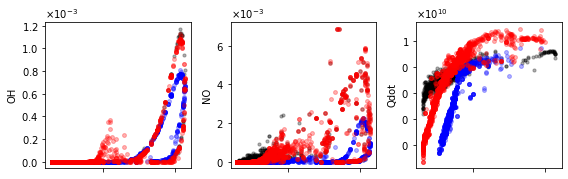

In [4]:
qssa_method_path = "../../figs/QSSA/data/"
rcce_method_path = "../../figs/RCCE_fortran/data/"

data_cols = ['OH', 'NO', 'Qdot']

# Initialize subplots
fig, axs = plt.subplots(3, 3, figsize=(8, 7), sharex=True)

# Define color for QSSA and RCCE scatter points
qssa_color = 'blue'
rcce_color = 'red'

# Define paths
original_data_path = os.path.join(data_path, case_name, target_case) + ".csv"
rcce_data_path = os.path.join(rcce_method_path, case_name, target_case, "predicted_X.csv")
qssa_data_path = os.path.join(qssa_method_path, case_name, target_case, "predicted_X.csv")

# Read data
df_original = pd.read_csv(original_data_path)
df_rcce = pd.read_csv(rcce_data_path)
df_qssa = pd.read_csv(qssa_data_path)

# Ensure T is a NumPy array
T = df_original['T'].to_numpy()

# Plot each variable in its corresponding subplot
for i, col in enumerate(data_cols):
    row, col_num = divmod(i, 3)
    ax = axs[row, col_num]
    
    # Scatter plot for original data
    ax.scatter(T[::3], 
            df_original[col].to_numpy()[::3],  # Convert to NumPy array
            label=f'{target_case} - Original', 
            s=10, 
            alpha=0.3, 
            marker='o', 
            color='black')  # Original data in black
    
    # Scatter plot for QSSA
    ax.scatter(T, 
            df_qssa[col].to_numpy(),  # Convert to NumPy array
            label=f'QSSA - {target_case}', 
            s=15, 
            alpha=0.3, 
            marker='o', 
            color=qssa_color)  # QSSA data in blue (scatter points)

    # Scatter plot for RCCE
    ax.scatter(T, 
            df_rcce[col].to_numpy(),  # Convert to NumPy array
            label=f'RCCE - {target_case}', 
            s=15, 
            alpha=0.3, 
            marker='o', 
            color=rcce_color)  # RCCE data in red (scatter points)

    # Log scale for Qdot (HRR) only
    if col == 'Qdot':
        ax.set_yscale('log')
        ax.set_ylabel('HRR (J/kg/s)', fontsize=10)  # Update label for Qdot

    # Formatting
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
    ax.yaxis.get_major_formatter().set_powerlimits((-2, 2))
    ax.set_ylabel(col, fontsize=10)
    # ax.set_xlim([1000, 2500])
    
    if row == 2:
        ax.set_xlabel('T(K)', fontsize=10)

# Remove extra subplots if there are fewer data columns
for j in range(len(data_cols), 9):
    fig.delaxes(axs[j // 3, j % 3])

# Tight layout for better spacing
plt.tight_layout()

# Save the figure
fig_dir = "figs/NH3_PaSR"
os.makedirs(fig_dir, exist_ok=True)
plt.savefig(os.path.join(fig_dir, "1D_CEQ_NH3_combine_Temperature.png"), dpi=300)
plt.show()


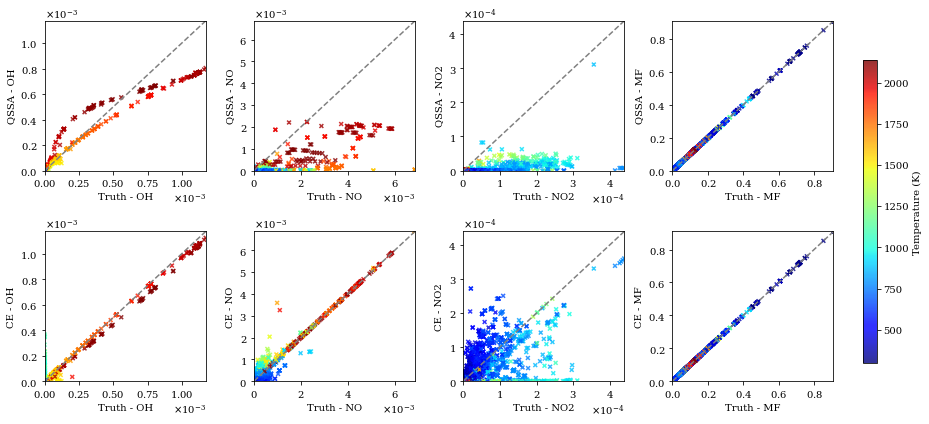

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
case_name = "PaSR"
data_cols = ['OH','NO', 'NO2', 'MF']

# Initialize subplots for 2 rows (QSSA, RCCE) and len(data_cols) columns
fig, axs = plt.subplots(2, len(data_cols), figsize=(3.2* len(data_cols), 6))

original_data_path = os.path.join(data_path, case_name, target_case) + ".csv"
rcce_data_path = os.path.join(rcce_method_path, case_name, target_case, "predicted_X.csv")
qssa_data_path = os.path.join(qssa_method_path, case_name, target_case, "predicted_X.csv")

# Read data
df_original = pd.read_csv(original_data_path)
df_rcce = pd.read_csv(rcce_data_path)
df_qssa = pd.read_csv(qssa_data_path)

# Ensure MF and T are NumPy arrays
MF = df_original['MF'].to_numpy()
T = df_original['T'].to_numpy()  # Temperature for coloring

# Create a reference scatter for the colorbar
sc_ref = None

for i, col in enumerate(data_cols):
    # QSSA subplot (row 0)
    ax = axs[0, i]
    sc = ax.scatter(df_original[col], 
                    df_qssa[col],  # QSSA vs. truth
                    c=T,           # Color by temperature
                    cmap='jet',
                    s=15, 
                    alpha=0.8, 
                    marker='x')
    if sc_ref is None:
        sc_ref = sc  # Store the first scatter as reference for the colorbar
    ax.set_ylabel(f'QSSA - {col}', fontsize=10)
    ax.set_xlabel(f'Truth - {col}', fontsize=10)
    
    
    # Plot the y=x line with dynamic range
    x_min, x_max = df_original[col].min(), df_original[col].max()
    ax.plot([x_min, x_max], [x_min, x_max], color='gray', linestyle='--', label='y=x')
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([x_min, x_max])

    # RCCE subplot (row 1)
    ax = axs[1, i]
    ax.scatter(df_original[col], 
               df_rcce[col],  # RCCE vs. truth
               c=T,           # Color by temperature
               cmap='jet',
               s=15, 
               alpha=0.8, 
               marker='x')
    ax.set_ylabel(f'CE - {col}', fontsize=10)
    ax.set_xlabel(f'Truth - {col}', fontsize=10)

    # Plot the y=x line for RCCE
    ax.plot([x_min, x_max], [x_min, x_max], color='gray', linestyle='--', label='y=x')
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([x_min, x_max])

    # Formatting axes for both rows of the current column
    for row in range(2):
        axs[row, i].xaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
        axs[row, i].yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
        axs[row, i].yaxis.get_major_formatter().set_powerlimits((-3, 3))
        axs[row, i].xaxis.get_major_formatter().set_powerlimits((-3, 3))

plt.tight_layout()

# Add a vertical colorbar for temperature using the reference scatter
# cbar = fig.colorbar(sc_ref, ax=axs, orientation='vertical', label='Temperature (K)')
plt.tight_layout(rect=[0, 0, 0.92, 1])  # Shrink plot area to make space for colorbar

# Add a colorbar to the right outside the plot
cbar_ax = fig.add_axes([0.94, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sc_ref, cax=cbar_ax)
cbar.set_label('Temperature (K)')
# Save the figure
fig_dir = "figs/NH3_PaSR"
os.makedirs(fig_dir, exist_ok=True)
plt.savefig(os.path.join(fig_dir, "QSSA_RCCE_vs_Original_MF.pdf"), dpi=300, bbox_inches='tight')
plt.show()